# ERA5 exercises

The brief:
    
1. Plot a map of the ERA5 T2M field.
2. Read in new observations [https://www.bas.ac.uk/project/reader/#data]
3. Plot the new observations on top of the ERA5 map
4. Extract ERA5 values at the lat.lon locations of the observations
5. Plot a scatter plot of the ERA5 versus the observed values  

In [2]:
#1a. Set up: 
import numpy as np
import scipy
import pandas as pd
import xarray as xr
import cartopy as ctp
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import BoundaryNorm
from matplotlib import cm
warnings.filterwarnings('ignore')
import os

os.chdir('/work/ollie/qigao001/finse_school')

from Finse_data_analysis.module.mapplot import (
         hemisphere_plot,
         globe_plot,
     )


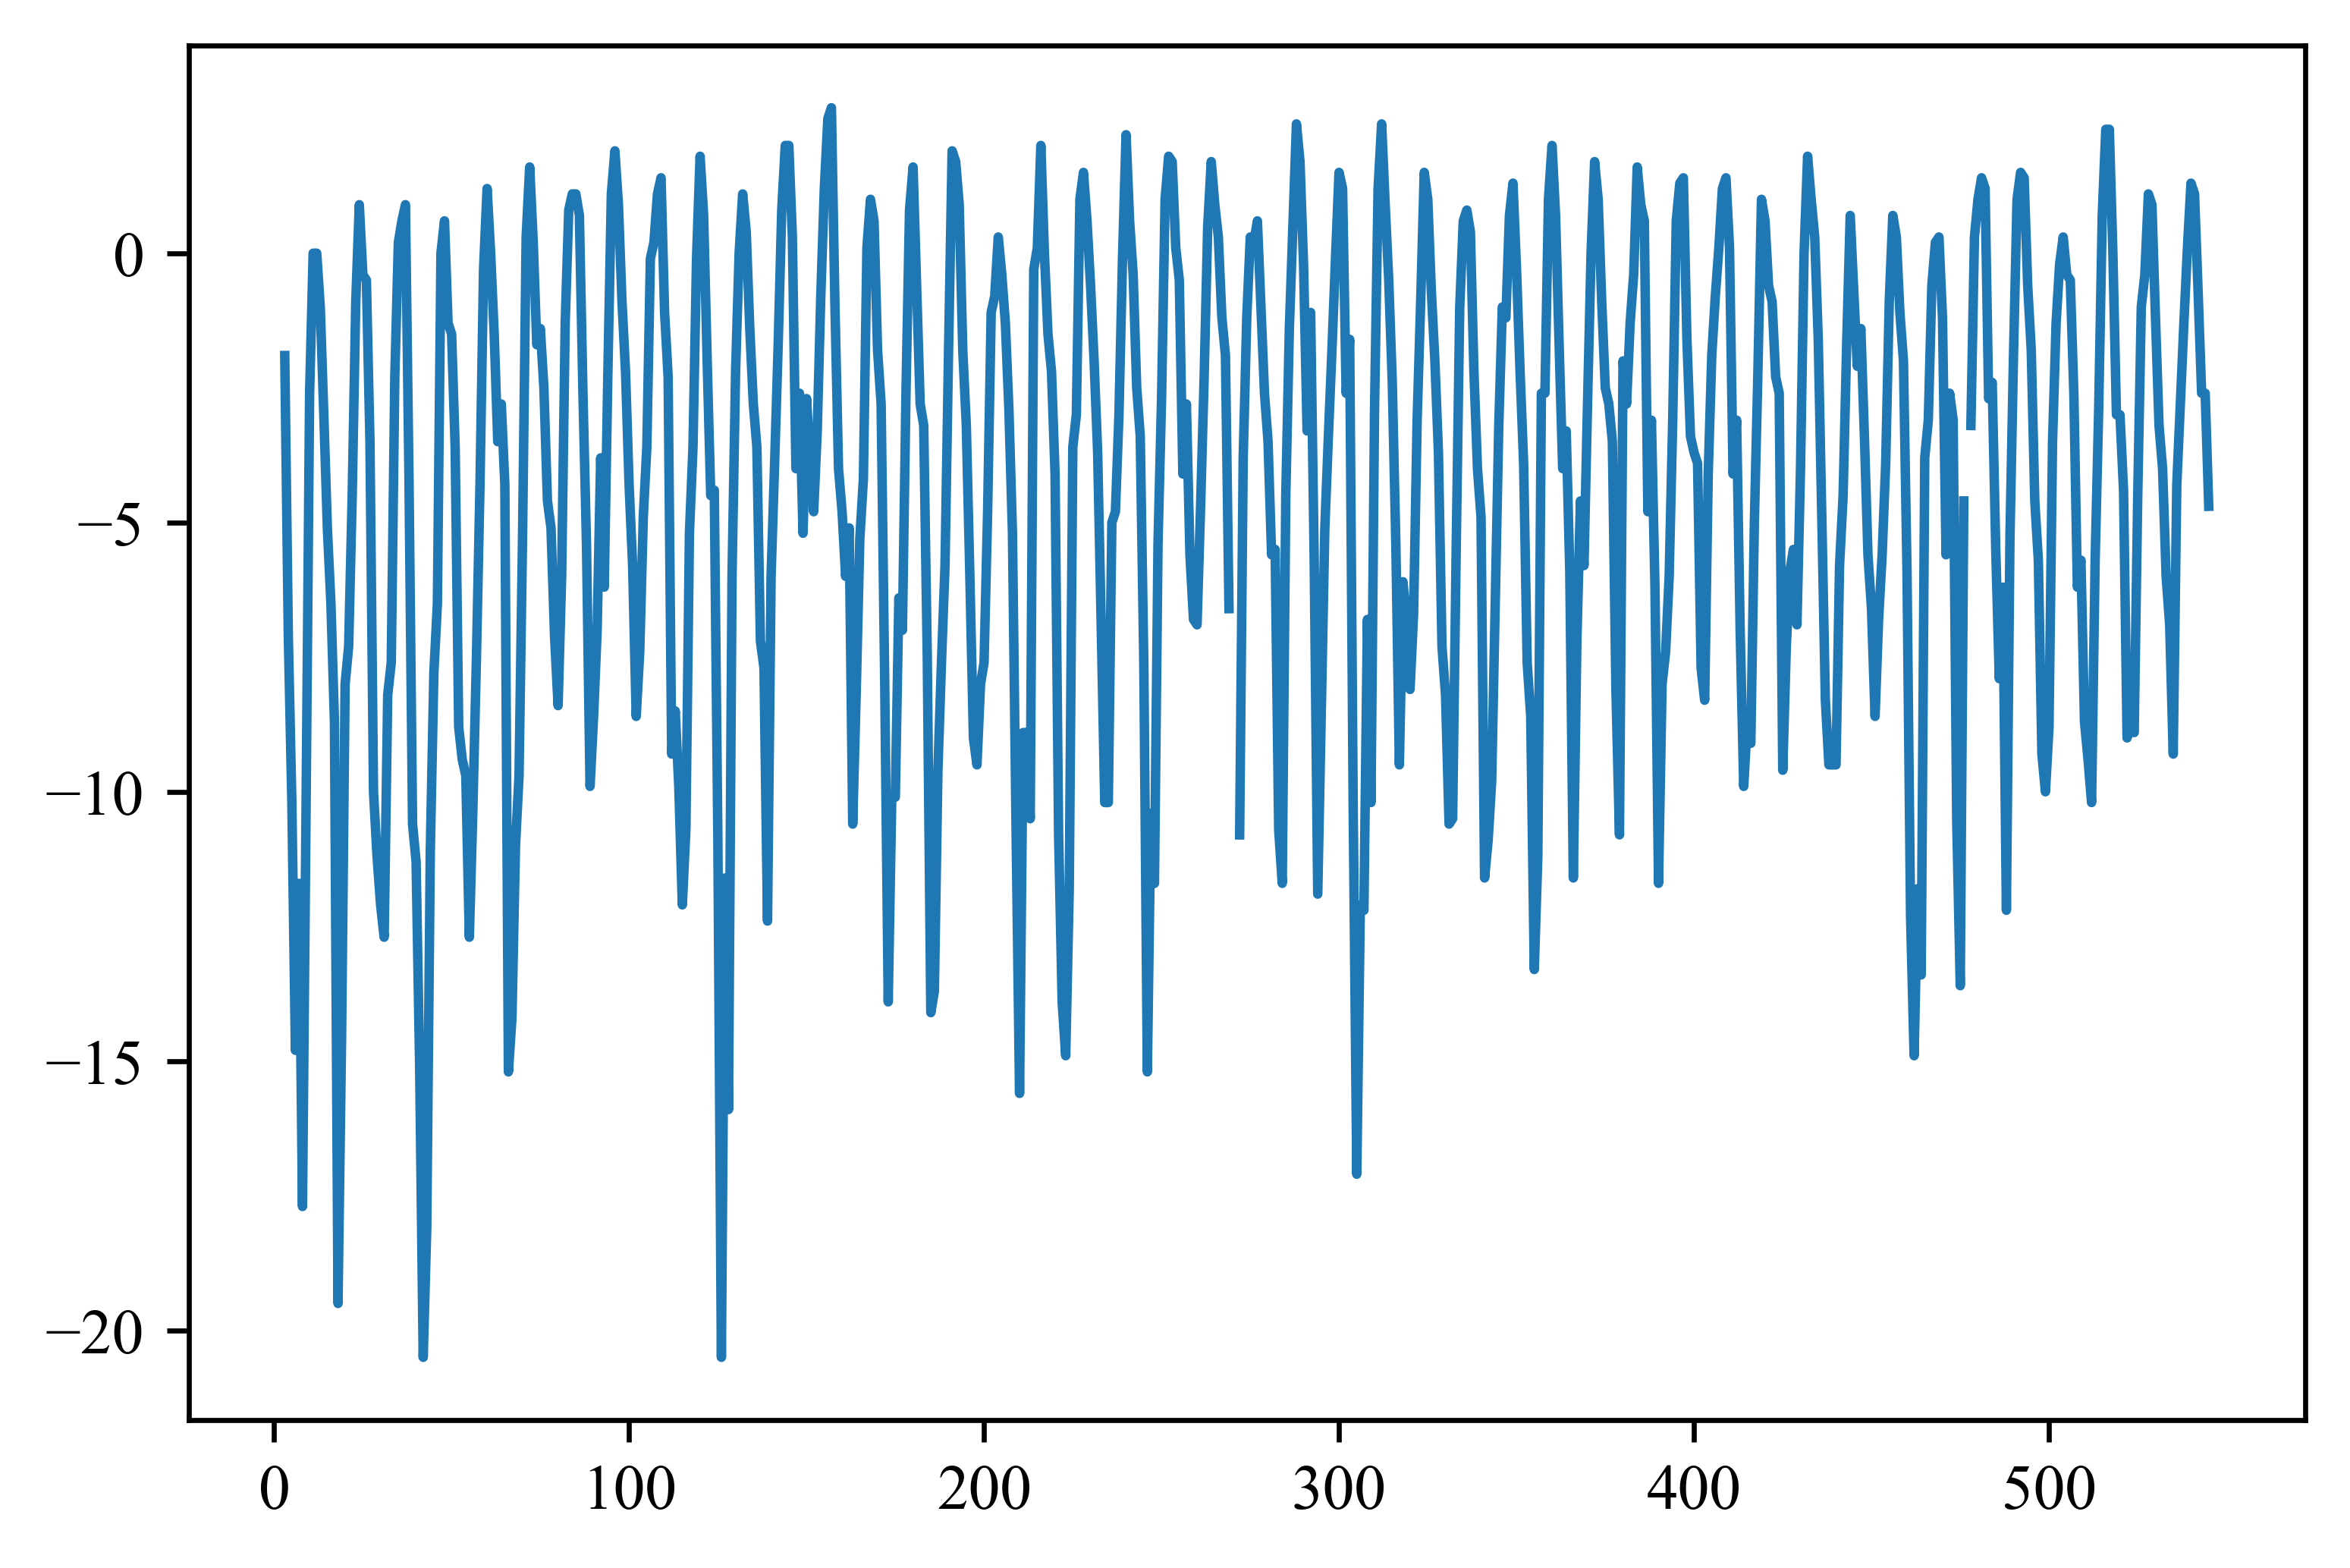

In [13]:
#1b. Read in new observations [https://www.bas.ac.uk/project/reader/#data]
#data = pd.read_csv('data\Antarctic_site_records\Rothera_temperature_2.csv', header=None, index_col=0 )
Rothera_1 = pd.read_csv('data/Antarctic_site_records/Rothera_temperature.csv', na_values=('-','nan'))
Rothera_1
R1=np.array(Rothera_1)
R2=R1[:,1:13]
np.prod(R2.shape)
R3=np.reshape(R2,(np.prod(R2.shape),1))
plt.plot(R3);


In [5]:
#2. Read in ERA5 data and all Turner observational data
era5_t2m = xr.open_dataset('data/ERA5/cdo_regridded_t2m_era5_1979_2020_annual_mean.nc')
Turner_sites = pd.read_csv('data/Antarctic_site_records/Turner_obs.csv')
Turner_sites.lon[16]=1
Turner_sites.lat[16]=-88.5
Obs_lat=np.array(Turner_sites.lat)
Obs_lon=np.negative(np.array(Turner_sites.lon))
obs_value=np.array(Turner_sites.temp)+273.15
print(np.array([Obs_lon, Obs_lat])) # check lons and lats of observational data
print(obs_value)


[[ 11.8  39.6  62.9  78.   93.  106.9 110.5 140.  166.7 -68.1 -64.4 -58.9
  -57.  -56.7 -44.7  -8.4  -1. ]
 [-70.8 -69.  -67.6 -68.6 -66.5 -78.5 -66.3 -66.7 -77.9 -67.5 -65.4 -62.2
  -63.4 -64.2 -60.7 -70.7 -88.5]]
[263.05 262.65 261.85 263.05 261.85 217.85 264.05 262.35 253.55 269.05
 270.25 271.05 268.55 265.05 270.05 257.15 223.65]


Text(0.5, 0, 'Annual mean 2m temperature [$K$] in ERA5')

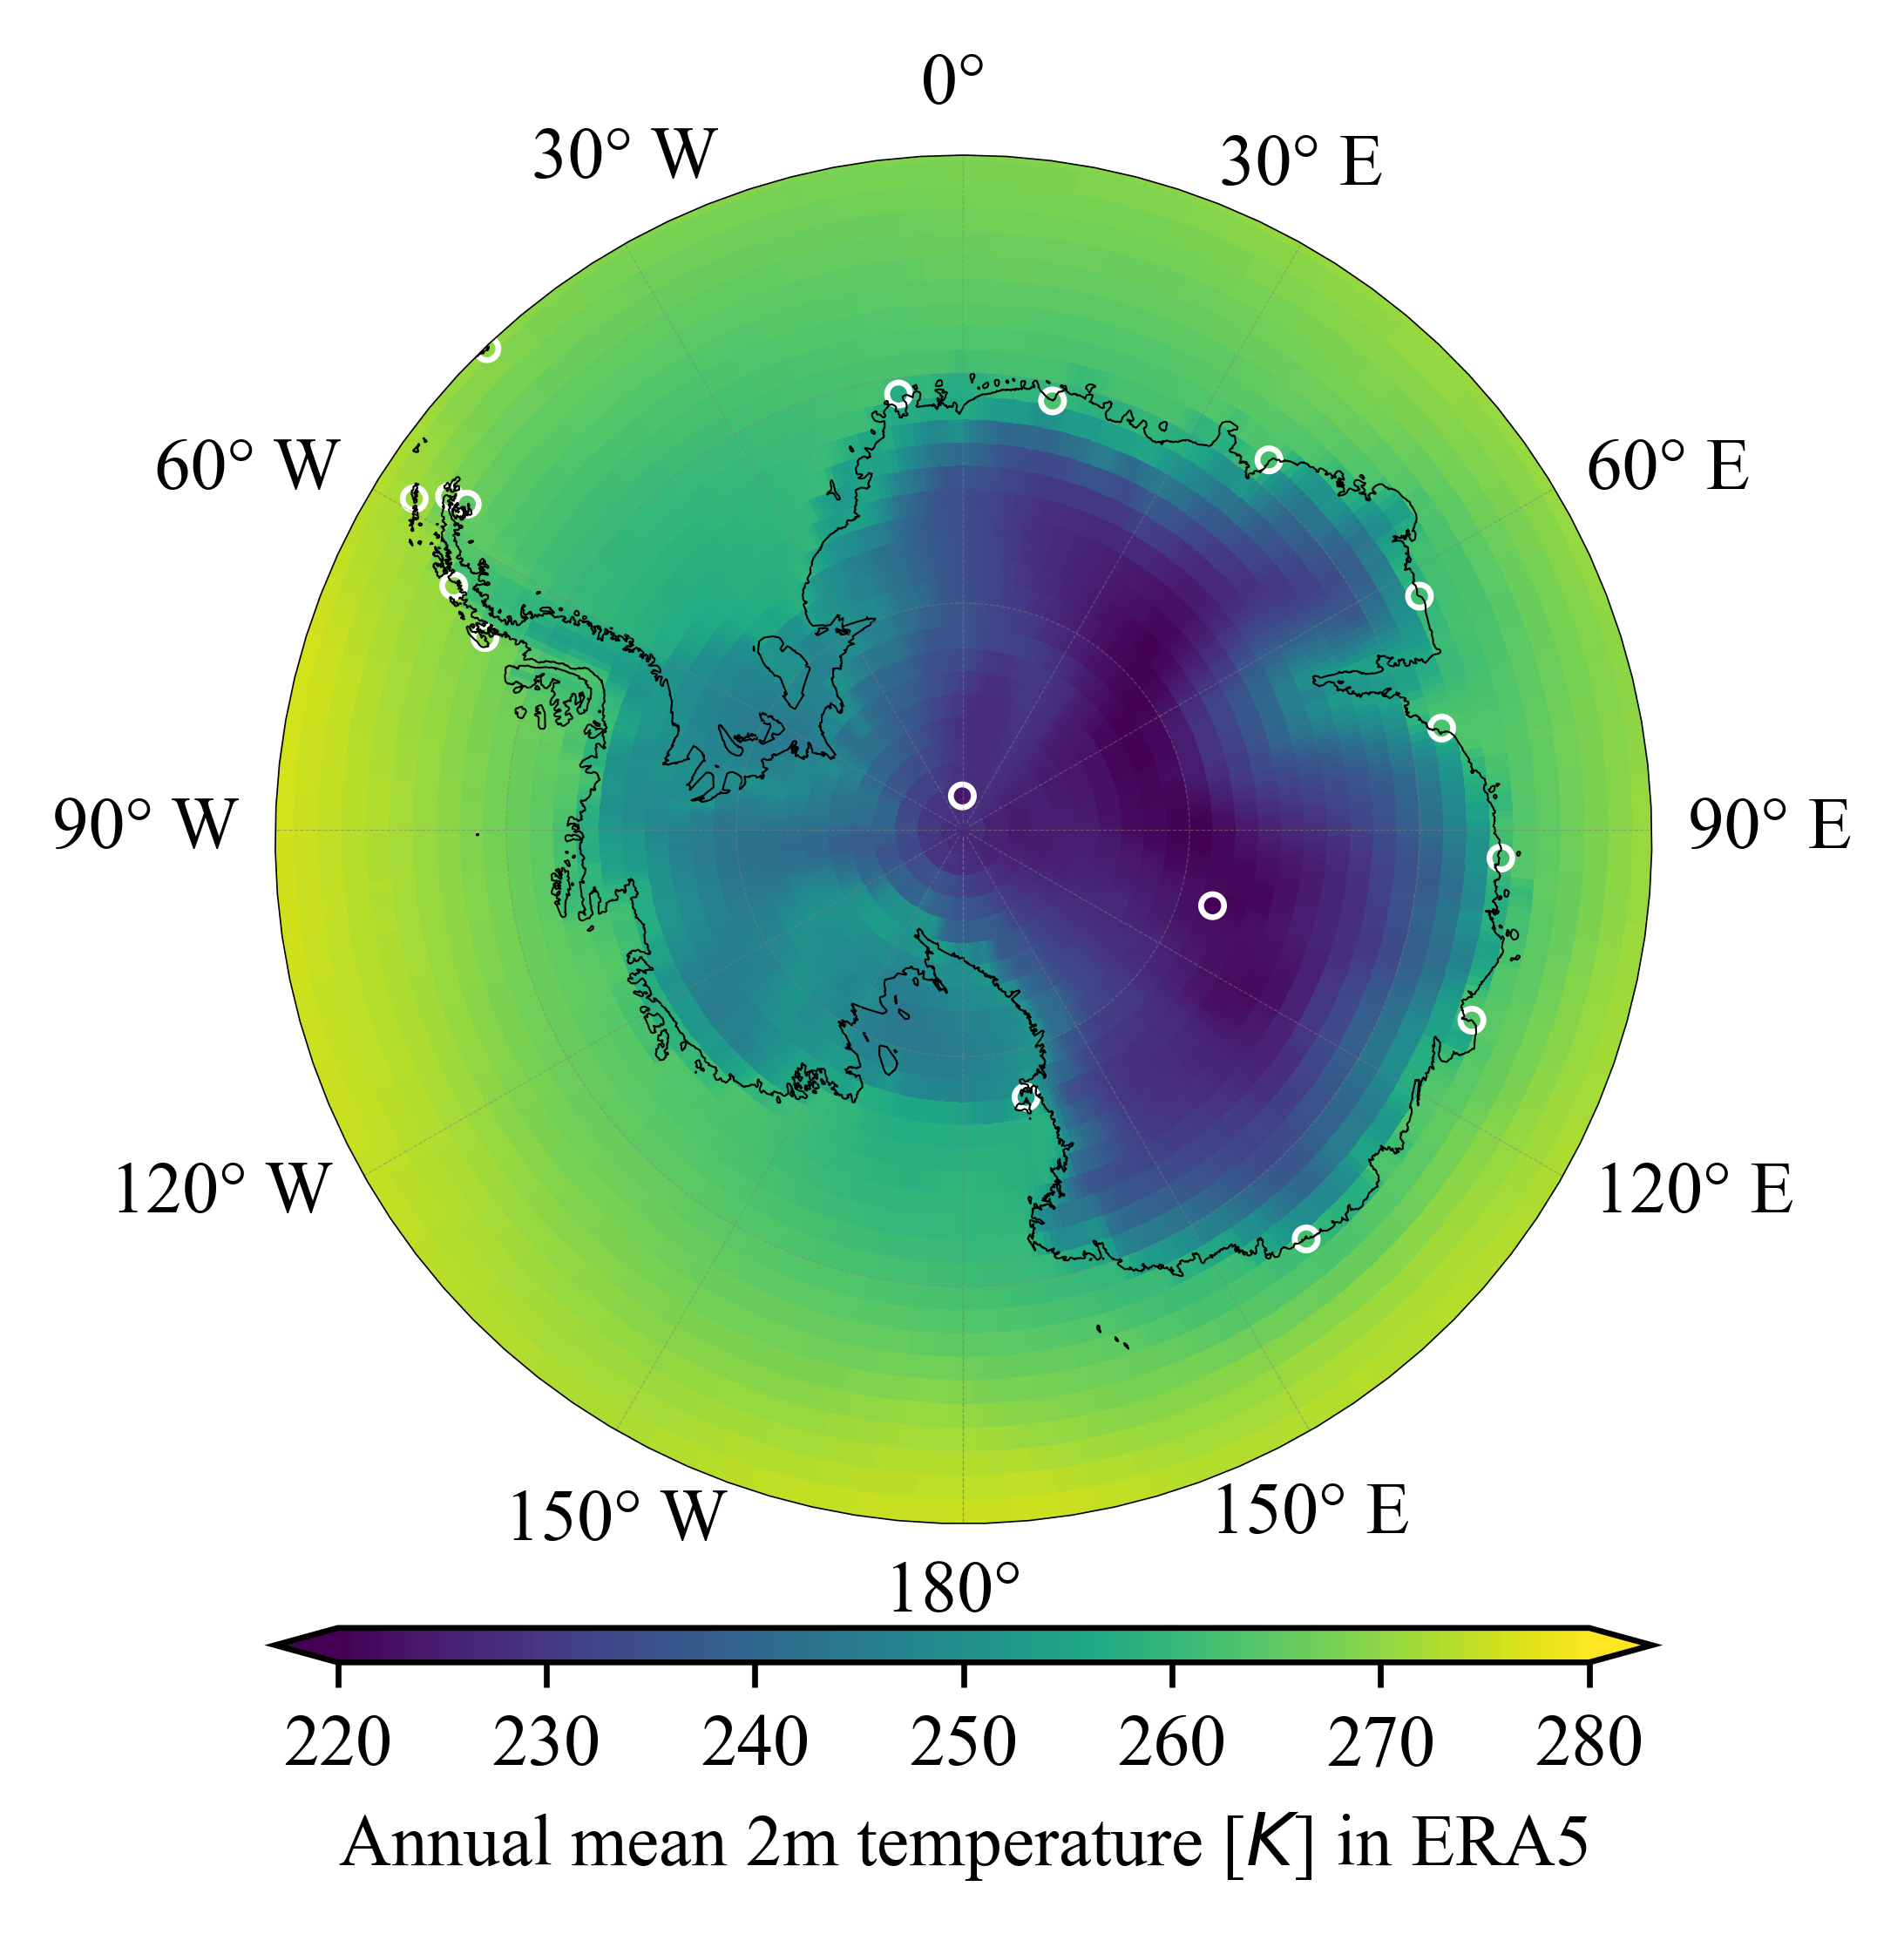

In [6]:
#3. Plot the new observations on top of the ERA5 map
pltlevel = np.arange(220, 280.01, 0.2)
pltticks = np.arange(220, 280.01, 10)

fig, ax = hemisphere_plot(northextent=-60,)

plt_cmp = ax.pcolormesh(
    era5_t2m.lon,
    era5_t2m.lat,
    era5_t2m.t2m.squeeze(),
    norm=BoundaryNorm(pltlevel, ncolors=len(pltlevel)),
    cmap=cm.get_cmap('viridis', len(pltlevel)),
    transform=ctp.crs.PlateCarree(),
)
plt_st = ax.scatter(
            x = Obs_lon, y = Obs_lat,
            s=10, linewidths=0.8,
            c = obs_value, marker='o',
            norm=BoundaryNorm(pltlevel, ncolors=len(pltlevel)),
            cmap=cm.get_cmap('viridis', len(pltlevel)),
            transform=ctp.crs.PlateCarree(), edgecolors = 'white',
        )

cbar = fig.colorbar(
    plt_cmp, ax=ax, orientation="horizontal", pad=0.02,
    fraction=0.16, shrink=1, aspect=40, anchor=(0.5, 0.7),
    ticks=pltticks, extend='both')
cbar.ax.set_xlabel(
    'Annual mean 2m temperature [$K$] in ERA5',
    linespacing=1.5
)

In [7]:
#4 Extract ERA5 data at the the lat lon values from Turner_obs.csv 

from scipy.interpolate import interpn
t2m=np.array(era5_t2m.t2m)
points = (np.array(era5_t2m.lon), np.array(era5_t2m.lat)) # tuple that interpn needs below [x,y]

t2m_flattened=np.reshape(t2m,(180,360)) # this removes the extra singleton dimension
#plt.pcolormesh(t2m_flattened)
# now do this for all the actual stations..

model_value=np.empty(17)

# 4. Extract ERA5 values at the observational lats and longs
for n in range(0, 17):
    my_point=(Obs_lon[n],Obs_lat[n])
    #print(n), print(my_point)
    model_value[n]=interpn(points, t2m_flattened.T, my_point)
    #print(model_value[n])
    

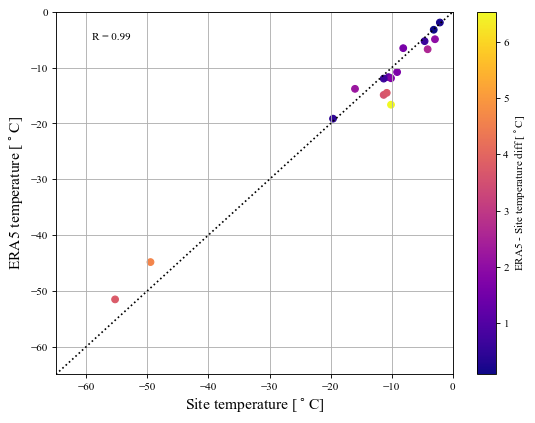

In [8]:
#5. Scatter plot of ERA5 versus observational values - colored by ERA5 error
obs_value=np.array(Turner_sites.temp)+273.15
#print(model_value-273.15)
#print(obs_value)

from matplotlib.pyplot import figure

C=np.corrcoef(obs_value-273.15, model_value-273.15)
C_str=str(round(C[1,0],2))
#fig, ax = plt.subplots(figsize=(6,6))

figure(figsize=(8, 6), dpi=80)
plt.scatter(obs_value-273.15, model_value-273.15,c = abs((model_value-obs_value)), cmap='plasma')
#plt.scatter(model_value-273.15,obs_value-273.15,c = abs((model_value-obs_value)-273.15), cmap='plasma')

plt.colorbar(label='ERA5 - Site temperature diff [$^\circ$C]')
plt.plot([-65,0],[-65,0], 'k:')
plt.xlabel('Site temperature [$^\circ$C]',fontsize=14)
plt.ylabel('ERA5 temperature [$^\circ$C]',fontsize=14)
plt.text(-59,-5,'R = ' + C_str)
plt.xlim([-65, 0])
plt.ylim([-65, 0])
plt.grid()
plt.savefig('ERA5_figure.png')

#ax.plot(obs_value, model_value-273.13, 'bs')
#ax.set_xlabel('Site temperature [$^\circ$C]',fontsize=14)
#ax.set_ylabel('ERA5 temperature [$^\circ$C]',fontsize=14)
#plt.text(-45,-5,'R = ' + C_str)
#ax.set_xlim([-50, 0])
#ax.set_ylim([-50, 0])
#plt.grid()

#plt.show()
